In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

In [ ]:
# Load data
X = np.load("X.npy")                    # Shape: (1500, 600, 12)
y = np.load("y.npy")                   # Shape: (1500, 1200, 12)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Y = y[:, 600:, :]                     # Shape: (1500, 600, 12)
print(X.shape, y.shape)

# normalization
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
Y_mean = Y.mean(axis=(0, 1), keepdims=True)
Y_std = Y.std(axis=(0, 1), keepdims=True)

X_norm = (X - X_mean) / (X_std + 1e-8)
Y_norm = (Y - Y_mean) / (Y_std + 1e-8)

# Flatten time dimension to fit the MLP
X_flat = X_norm.reshape(X.shape[0], -1)  # (1500, 600*12)
Y_flat = Y_norm.reshape(Y.shape[0], -1)  # (1500, 600*12)


X_tensor = torch.tensor(X_flat, dtype=torch.float32)
Y_tensor = torch.tensor(Y_flat, dtype=torch.float32)

# Dataset and loader
full_dataset = TensorDataset(X_tensor, Y_tensor)

# Split into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

(1500, 600, 12) (1500, 1200, 12)


In [ ]:
# Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #fully connected feedforward neural network with 4 layers and Tanh activations.
        self.net = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.Tanh(),
            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [68]:
# Train function
def train(model, train_loader, val_loader, epochs=80, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_loss += criterion(model(x_val), y_val).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "mlp_3body_best.pth")


In [ ]:
def evaluate_and_plot(model, dataset, sample_idx, y_mean, y_std):
    import torch
    import matplotlib.pyplot as plt


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Get a sample
    x, y_true = dataset[sample_idx]  
    x = x.unsqueeze(0).to(device)    

    with torch.no_grad():
        y_pred = model(x).cpu().squeeze(0).numpy()  

    # Reshape for inverse transform
    y_true = y_true.numpy().reshape(1, -1)
    y_pred = y_pred.reshape(1, -1)

    # Inverse transform using standardization
    y_true_real = (y_true * y_std + y_mean).reshape(600, 12)
    y_pred_real = (y_pred * y_std + y_mean).reshape(600, 12)

    # Plot trajectories
    colors = ['blue', 'limegreen', 'crimson']
    plt.figure(figsize=(6, 6))
    for body_idx in range(3):
        xi, yi = 4 * body_idx, 4 * body_idx + 1

        if body_idx == 0:
            plt.plot(y_true_real[:, xi], y_true_real[:, yi], label='Ground Truth', color="black", linewidth=2)
        else:
            plt.plot(y_true_real[:, xi], y_true_real[:, yi], color="black", linewidth=2)

        plt.plot(y_pred_real[:, xi], y_pred_real[:, yi], label=f'Pred Body {body_idx + 1}',
                 color=colors[body_idx], linestyle='--', alpha=0.8)

    plt.xlim(-0.75, 0.75)
    plt.title("Predicted vs Ground Truth MLP", fontsize=18, pad=20)
    plt.xlabel("X-position", fontsize=16)
    plt.ylabel("Y-position", fontsize=16)
    plt.legend(fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()


In [ ]:
input_dim = X_tensor.shape[1]         # 600 * 12 = 7200
output_dim = Y_tensor.shape[1]        # 600 * 12 = 7200
model = MLP(input_dim, output_dim)

#Train model
train(model, train_loader, val_loader, epochs=80, lr=1e-3)

model.eval()
with torch.no_grad():
    predictions = model(X_tensor.to(device)).cpu().numpy()  # Apply model on entire input set

# Expand y_mean och y_std to (1, 7200) 
expanded_y_mean = np.tile(Y_mean.reshape(1, 1, 12), (1, 600, 1)).reshape(1, -1)
expanded_y_std = np.tile(Y_std.reshape(1, 1, 12), (1, 600, 1)).reshape(1, -1)

Y_pred_real = predictions * expanded_y_std + expanded_y_mean
Y_true_real = Y_tensor.numpy() * expanded_y_std + expanded_y_mean



np.save("predicted_y_next_1000.npy", Y_pred_real)


Epoch 1 | Train Loss: 0.852987 | Val Loss: 0.864747
Epoch 2 | Train Loss: 0.696271 | Val Loss: 0.667501
Epoch 3 | Train Loss: 0.571711 | Val Loss: 0.587378
Epoch 4 | Train Loss: 0.520127 | Val Loss: 0.559088
Epoch 5 | Train Loss: 0.493920 | Val Loss: 0.554919
Epoch 6 | Train Loss: 0.498389 | Val Loss: 0.537383
Epoch 7 | Train Loss: 0.477232 | Val Loss: 0.526479
Epoch 8 | Train Loss: 0.468836 | Val Loss: 0.512123
Epoch 9 | Train Loss: 0.463531 | Val Loss: 0.526659
Epoch 10 | Train Loss: 0.457716 | Val Loss: 0.514591
Epoch 11 | Train Loss: 0.449821 | Val Loss: 0.496214
Epoch 12 | Train Loss: 0.452091 | Val Loss: 0.491683
Epoch 13 | Train Loss: 0.446840 | Val Loss: 0.489553
Epoch 14 | Train Loss: 0.450563 | Val Loss: 0.504462
Epoch 15 | Train Loss: 0.441776 | Val Loss: 0.496830
Epoch 16 | Train Loss: 0.433837 | Val Loss: 0.483153
Epoch 17 | Train Loss: 0.434931 | Val Loss: 0.490541
Epoch 18 | Train Loss: 0.425113 | Val Loss: 0.466166
Epoch 19 | Train Loss: 0.422459 | Val Loss: 0.470718
Ep

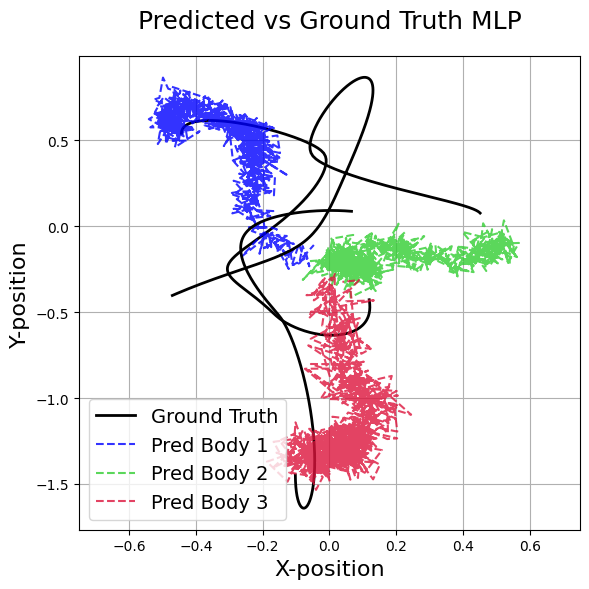

In [76]:
evaluate_and_plot(model, full_dataset, sample_idx=22, y_mean = expanded_y_mean, y_std = expanded_y_std)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, r2_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=7200, output_dim=7200).to(device)
model.load_state_dict(torch.load("mlp_3body_best.pth"))
model.eval()

total_mse = 0.0
total_mae = 0.0
r2_scores = []

with torch.no_grad():
    for val_X, val_y in val_loader:
        val_X, val_y = val_X.to(device), val_y.to(device)
        
        outputs = model(val_X)  # (batch, 7200)

    
        total_mse += nn.functional.mse_loss(outputs, val_y, reduction='sum').item()
        total_mae += nn.functional.l1_loss(outputs, val_y, reduction='sum').item()
        
        pred_np = outputs.cpu().numpy()
        true_np = val_y.cpu().numpy()
        r2_scores.append(r2_score(true_np, pred_np))

# Normalisering per element
num_elements = len(val_dataset) * 7200
avg_mse = total_mse / num_elements
avg_mae = total_mae / num_elements
avg_r2 = np.mean(r2_scores)

print(f"\nValidation MSE: {avg_mse:.6f}")
print(f"Validation MAE: {avg_mae:.6f}")
print(f"Validation R² Score: {avg_r2:.4f}")



Validation MSE: 0.387221
Validation MAE: 0.358912
Validation R² Score: 0.6323
